In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from scipy.stats import gaussian_kde

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
%matplotlib inline

In [21]:
#df_stations = pd.read_csv('../Downloads/open_data_year_one/2015_station_data.csv')
df_trips = pd.read_csv('open_data_year_one/2015_trip_data.csv')
#df_status = pd.read_csv('../Downloads/open_data_year_one/2015_status_data.csv')
#df_weather = pd.read_csv('../Downloads/open_data_year_one/2015_weather_data.csv')


# 1. Cleaning

In [4]:
print df_trips.info() 
print df_trips.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142846 entries, 0 to 142845
Data columns (total 12 columns):
trip_id              142846 non-null int64
starttime            142846 non-null object
stoptime             142846 non-null object
bikeid               142846 non-null object
tripduration         142846 non-null float64
from_station_name    142846 non-null object
to_station_name      142846 non-null object
from_station_id      142846 non-null object
to_station_id        142846 non-null object
usertype             142846 non-null object
gender               87360 non-null object
birthyear            87360 non-null float64
dtypes: float64(2), int64(1), object(9)
memory usage: 14.2+ MB
None
   trip_id         starttime          stoptime    bikeid  tripduration  \
0      431  10/13/2014 10:31  10/13/2014 10:48  SEA00298       985.935   
1      432  10/13/2014 10:32  10/13/2014 10:48  SEA00195       926.375   
2      433  10/13/2014 10:33  10/13/2014 10:48  SEA00486       883.831  

In [67]:
# Missing values in gender and birthyear columns
# Date columns need to be converted
# Convert tripduration to  minutes
# Drop station_name columns and trip_id

In [22]:
df_trips['date'] = df_trips['starttime'].str.replace(' .*','')
df_trips['starttime'] = pd.to_datetime(df_trips['starttime'])
# df_trips['stoptime'] = pd.to_datetime(df_trips['stoptime'])

df_trips['tripduration'] = df_trips['tripduration'] / 60

df_trips = df_trips.drop(['from_station_name', 'to_station_name', 'trip_id'], axis = 1)

# 2. Preliminary EDA

In [22]:
def plot_hist(df, columns):
    
    for col in columns:
        data = df[col]
        plt.hist(data, range = [data.min(), data.max()], bins = 20, normed = True)
        x = np.linspace(data.min(), data.max(), 100)
        density = gaussian_kde(data.dropna())
        plt.plot(x, density(x), color = 'r')
        plt.title(col)
        plt.show()

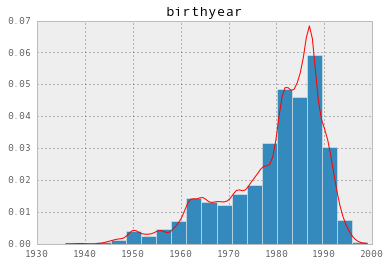

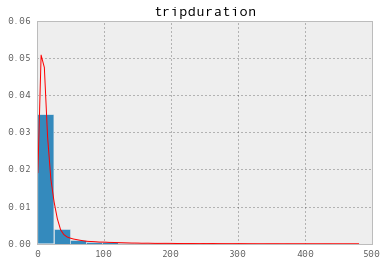

In [80]:
plot_hist(df_trips, ['birthyear', 'tripduration'])

In [ ]:
# Tripdurations are usually small, must investigate outliers (large and small)
# Birthyear looks normal, should compare with age distribution near pronto bike stations

In [149]:
df_trips.describe().T

,count,mean,std,min,25%,50%,75%,max
tripduration,142846,20.182287,34.938045,1.000133,6.60605,10.769317,19.285758,479.906633
birthyear,87360,1979.637843,10.140537,1936.000000,1974.00000,1982.000000,1987.000000,1999.000000


In [ ]:
# Tripduration have small and large outliers, max is 7 hours and min is 1 minute! 
# Will need to keep in mind!

In [97]:
# Now for categorical variables 
print 'gender count:'
print df_trips['gender'].value_counts()
print '\n'
print 'usertype count:'
print df_trips['usertype'].value_counts()

gender count:
Male      67608
Female    18245
Other      1507
dtype: int64


usertype count:
Annual Member             87360
Short-Term Pass Holder    55486
dtype: int64


In [98]:
# Way more males than females!
# Lots of short-term rides, should add weekend/holiday/tourism_season features
# Unfortunately no rider ID column, would have be very insightful

In [28]:
# Now for stations
s_fs = df_trips.groupby(['from_station_id'])['from_station_id'].count()
s_ts = df_trips.groupby(['to_station_id'])['to_station_id'].count()
df_sc = pd.concat([s_fs, s_ts], axis = 1)
df_sc.columns = ['from', 'to']
df_sc['total'] = df_sc['from'] + df_sc['to']
df_sc = df_sc.sort('total', ascending = True)

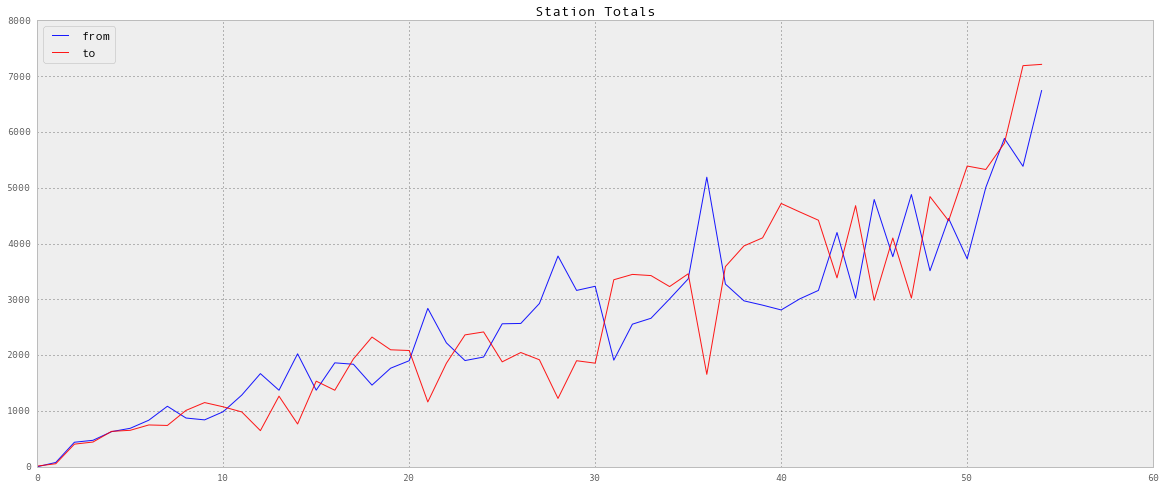

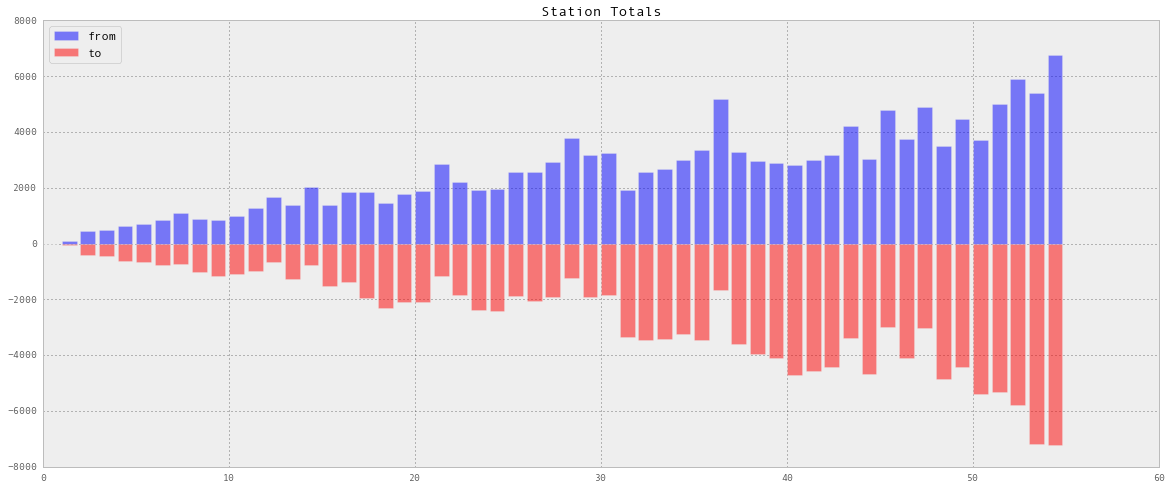

In [33]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(0,len(df_sc)), df_sc['from'], label='from', color = 'blue',  alpha=0.9)
plt.plot(np.arange(0,len(df_sc)), df_sc['to'], label = 'to', color = 'red',  alpha=0.9)
plt.legend(loc='upper left')
plt.title('Station Totals')
plt.show()

plt.figure(figsize=(20,8))
plt.bar(np.arange(0,len(df_sc)), df_sc['from'], label='from', color = 'blue',  alpha=0.5)
plt.bar(np.arange(0,len(df_sc)), df_sc['to']* -1, label = 'to', color = 'red',  alpha=0.5)
plt.legend(loc='upper left')
plt.title('Station Totals')
plt.show()


In [152]:
# To and from numbers follow similar trend, however many are unequal
# Should get elevation data from google maps api and compare
# look into stations with zero
# Look at totals subsetted by date and time features
# Check for accidental rentals i.e. < 1 minute with same start and end station
# Check for joy rides i.e. longer with same start and end station

       count        mean        std  min  25%  50%  75%  max
count    482  296.360996  77.266544    1  276  315  343  411


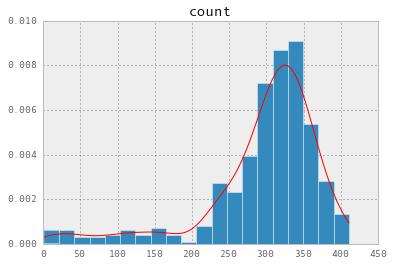

In [26]:
# Bike ID
s_bc = df_trips.groupby('bikeid').count()['stoptime']
df_bc = pd.DataFrame(s_bc.values, columns = ['count'])
print df_bc.describe().T
plot_hist(df_bc, ['count'])

In [13]:
# Left skewed: lots of new bikes?
# Should investigate differences (routes, locations, usage) between outliers and non-outliers 

Index([u'starttime', u'stoptime', u'bikeid', u'tripduration',
       u'from_station_id', u'to_station_id', u'usertype', u'gender',
       u'birthyear'],
      dtype='object')

In [6]:
# Predict if there will a shortage of bikes!
# maybe try time series and flag when they getting low 
# or just use status data set and mark when they are low
# my visual component would be which ones need more bikes!

# 2. Feature Engineering

In [34]:
# categorical: hour, dow, month, year, unused/broken bike, accidental rides, 
#     long rides, commute to work, commute from work, season, high tourism, weekend, station to station

In [24]:
#df_trips['date'] = df_trips['starttime'].map(lambda x: x.date())
df_trips['hour'] = df_trips['starttime'].map(lambda x: x.hour)
# df_trips['dayofweek'] = df_trips['starttime'].map(lambda x: x.dayofweek)
# df_trips['month'] = df_trips['starttime'].map(lambda x: x.month)
# df_trips['startminute'] = df_trips['starttime'].map(lambda x: x.minute)
# df_trips['season'] = df_trips['starttime'].map(lambda x: x.quarter)
# df_trips['year'] = df_trips['starttime'].map(lambda x: x.year)
# df_trips['day'] = df_trips['starttime'].map(lambda x: x.day)

In [ ]:
# Examining trip duration in more detail in order to engineer some features

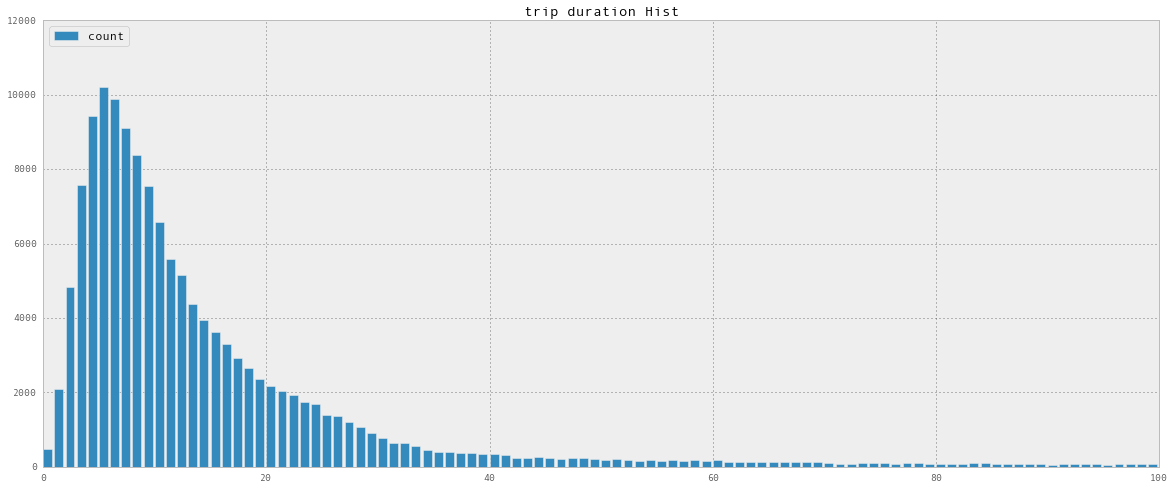

In [91]:
x = df_trips['tripduration'].round().value_counts()
x = x.sort_index()


plt.figure(figsize=(20,8))
plt.bar(np.arange(0,len(x[:100])), x[:100], label='count')
plt.legend(loc='upper left')
plt.title('trip duration Hist')
plt.show()

In [ ]:
# some very short trips as expected, many could be accidents.
# I will compare distributions of trips with the same start and finish station to those with differents stations
# Perhaps further analysis larger outliers could be informative i.e. by season to find joy rides

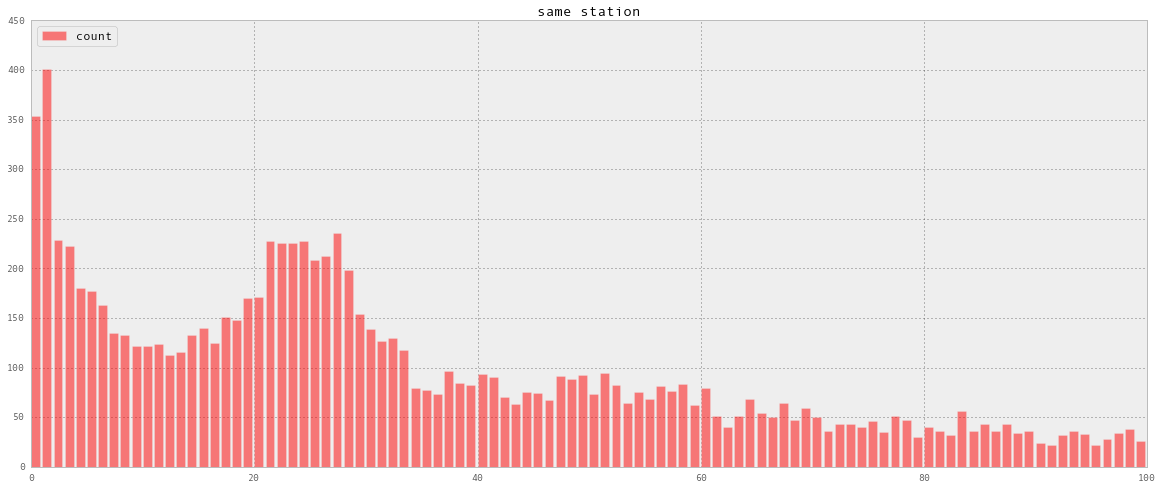

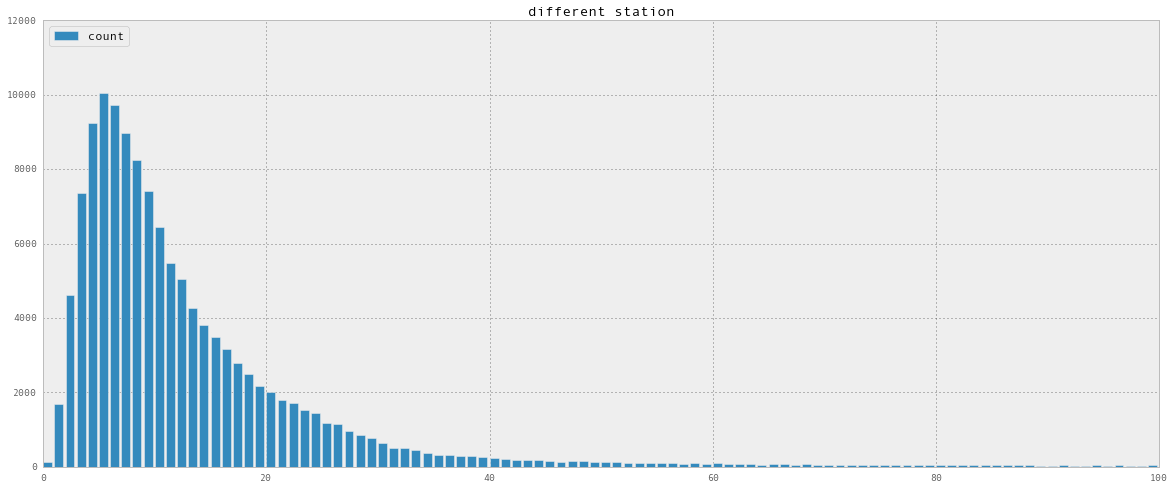

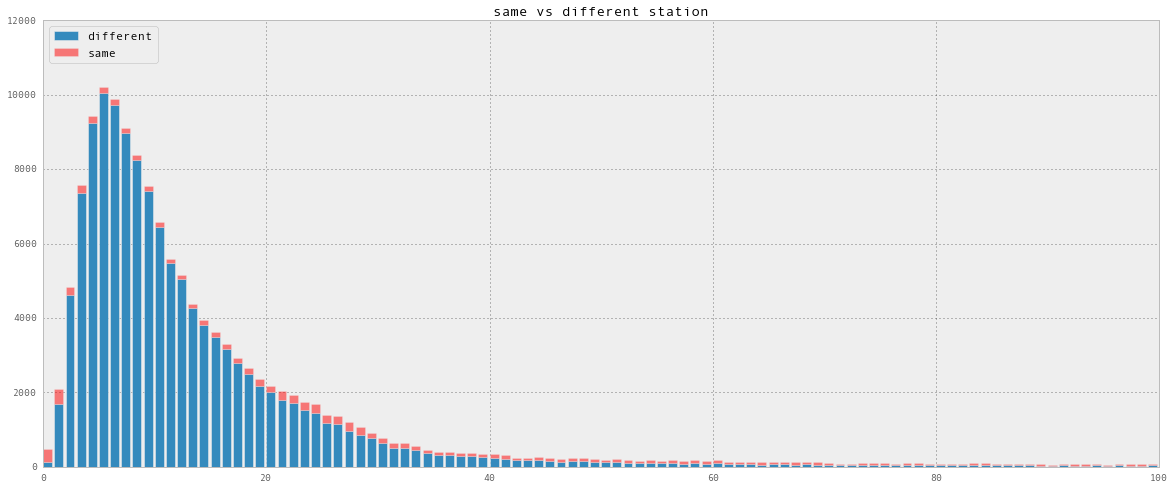

In [12]:
df_ss = df_trips.ix[df_trips['from_station_id'] == df_trips['to_station_id'], ['tripduration','to_station_id','from_station_id']] 
df_ds = df_trips.ix[df_trips['from_station_id'] != df_trips['to_station_id'], ['tripduration','to_station_id','from_station_id']]

x = df_ss['tripduration'].round().value_counts()
x = x.sort_index()

plt.figure(figsize=(20,8))
plt.bar(np.arange(0,len(x[:100])), x[:100], label='count', color = 'red', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('same station')
plt.show()

y = df_ds['tripduration'].round().value_counts()
y = y.sort_index()

plt.figure(figsize=(20,8))
plt.bar(np.arange(0,len(y[:100])), y[:100], label='count')
plt.legend(loc='upper left')
plt.title('different station')
plt.show()

plt.figure(figsize=(20,8))
plt.bar(np.arange(0,len(y[:100])), y[:100], label='different')
plt.bar(np.arange(0,len(x[:100])), x[:100], bottom =y[:100] ,label='same', color = 'red', alpha = 0.5)
plt.legend(loc='upper left')
plt.title('same vs different station')
plt.show()

In [95]:
# The y-axis are different in first two, must keep in mind. 
# Looks like lots of accidental bike rentals that were quickly put back on the rack
# could check to see if bikes were used again afterwards if need be
# Bulk of same station from 16-33, when different stations peak around 7-15 minutes
# Same station could be used for errands mainly for people with subscriptions

# I must query google to find distances/times it takes to get from station to station
# I will do that in a separate sheet

In [202]:
df_totals = df_trips.groupby(['from_station_id','to_station_id'])['gender'].count().reset_index()
df_traffic = df_totals.pivot(index = 'from_station_id', columns = 'to_station_id', values = 'gender')

In [203]:
df_traffic.fillna(0, inplace = True)

In [25]:
df_new = df_trips.groupby(['from_station_id','hour','date'])['bikeid'].count().reset_index()

In [26]:
df_new.to_csv('bikecounts.csv', index = False)

In [496]:
df_weather = pd.read_csv('open_data_year_one/2015_weather_data.csv')


In [497]:
df_weather['Date'] = df_weather['Date'].str.replace('/','-')
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather['Date'] = map(lambda x: x.date(),df_weather['Date'])
df_weather.rename(columns = {'Date': 'date'}, inplace = True)
df_weather['date'] = df_weather['date'].astype(str)
df_new['date'] = df_new['date'].astype(str)

In [498]:
dff = df_weather.merge(df_new, on='date', how='inner')

In [501]:
dff.to_csv('regression_data.csv', index = False)

In [507]:
from pandas.tools.plotting import scatter_matrix

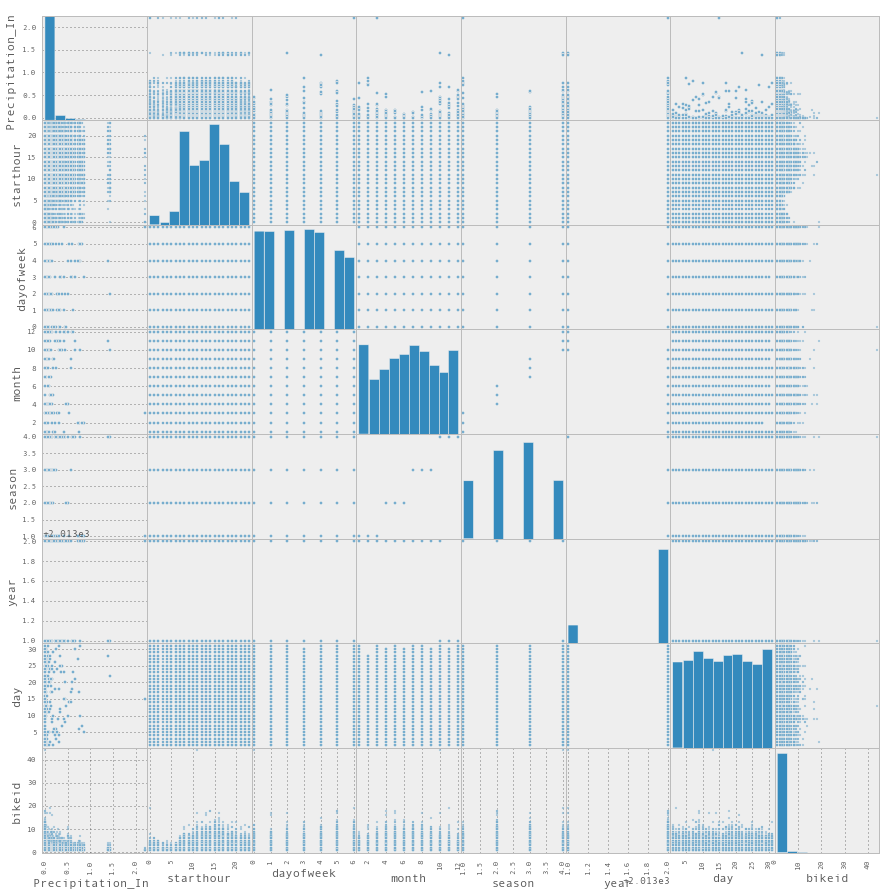

In [515]:
plt.figure(figsize=(20,8))
scatter_matrix(dff[dff.columns[-10:]],figsize=(15, 15))
plt.show()

In [531]:
dff.columns[1:21].union(dff.columns[-1:])

Index([u'Events', u'Max_Dew_Point_F', u'Max_Gust_Speed_MPH', u'Max_Humidity',
       u'Max_Sea_Level_Pressure_In ', u'Max_Temperature_F',
       u'Max_Visibility_Miles ', u'Max_Wind_Speed_MPH ', u'MeanDew_Point_F',
       u'Mean_Humidity ', u'Mean_Sea_Level_Pressure_In ',
       u'Mean_Temperature_F', u'Mean_Visibility_Miles ',
       u'Mean_Wind_Speed_MPH ', u'Min_Dewpoint_F', u'Min_Humidity ',
       u'Min_Sea_Level_Pressure_In ', u'Min_TemperatureF',
       u'Min_Visibility_Miles ', u'Precipitation_In ', u'bikeid'],
      dtype='object')

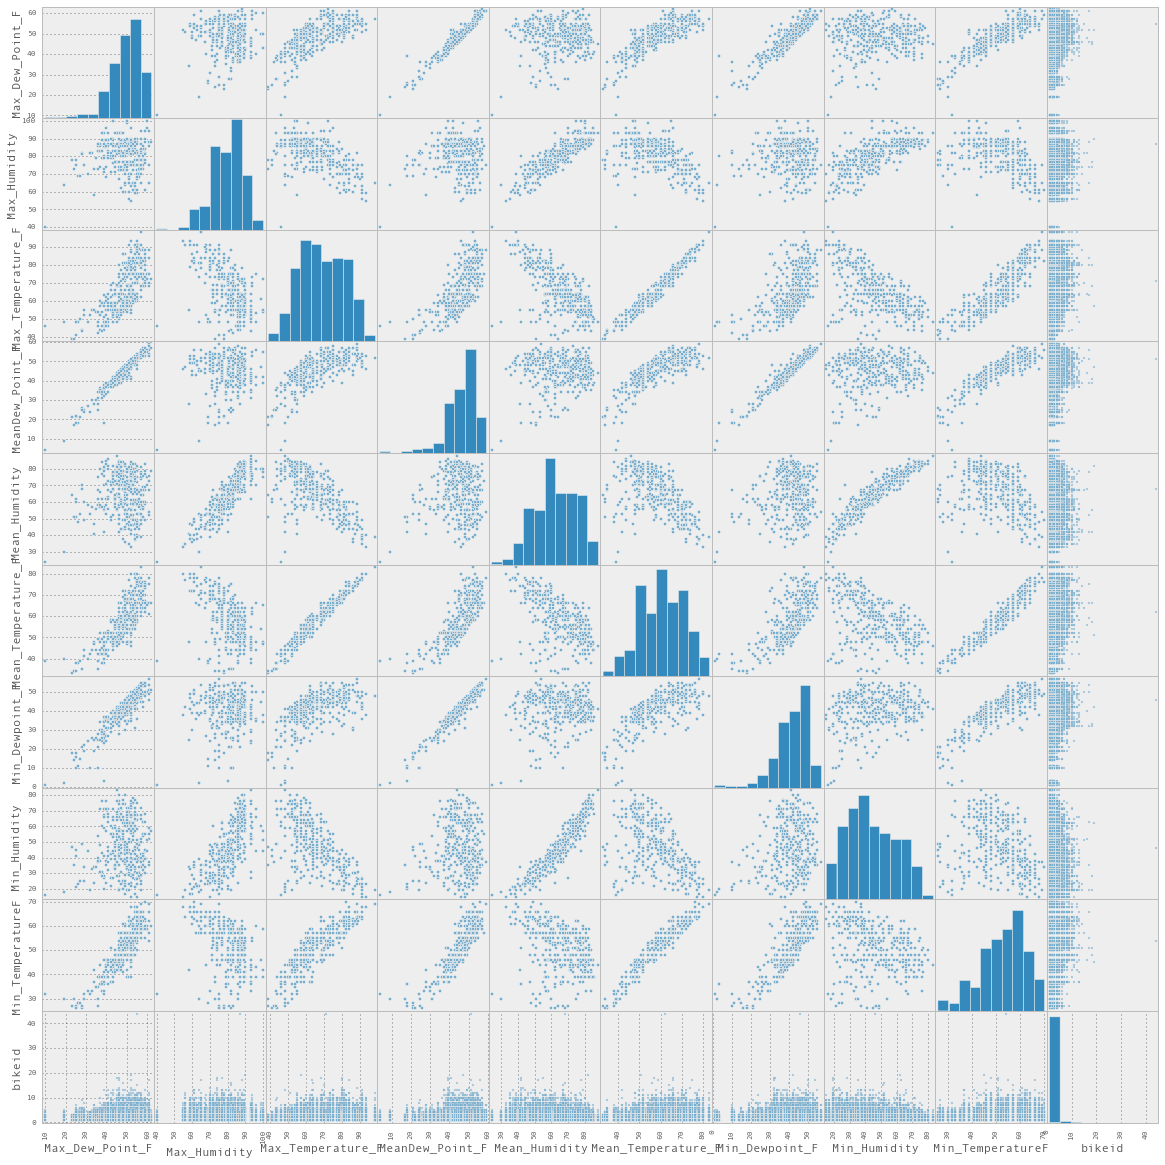

In [536]:
scatter_matrix(dff[dff.columns[1:10].union(dff.columns[-1:])],figsize=(20, 20))
plt.show()

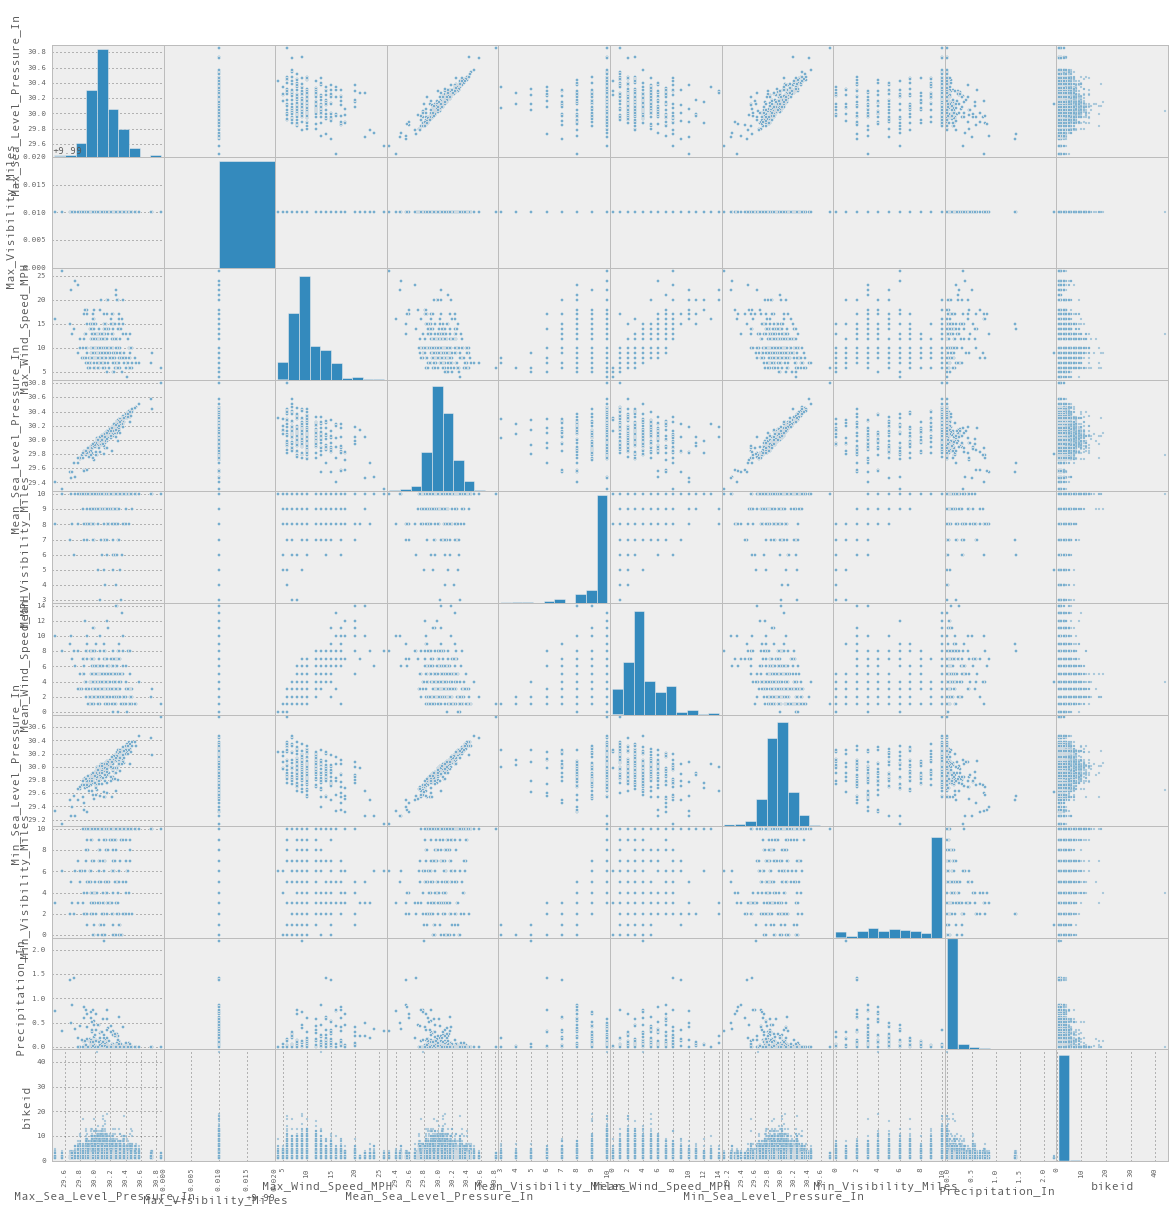

In [537]:
scatter_matrix(dff[dff.columns[10:20].union(dff.columns[-1:])],figsize=(20, 20))
plt.show()

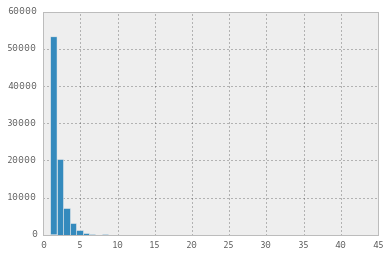

In [543]:
plt.hist(dff.bikeid, bins = 50)
plt.show()

In [546]:
df_trips.to_csv('new_trips.csv', index = False)

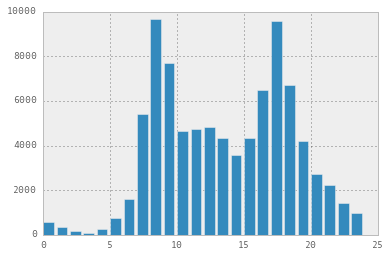

In [34]:
plt.bar(np.arange(24),df_trips.groupby(['hour'])['gender'].count())
plt.show()